In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing

### Load data

In [2]:
filename = 'data_model5_5kpa_12-16-2022.csv'
df = pd.read_csv(filename)
df.drop(['Unnamed: 0', 'WIDTH_sub', 'HEIGHT_sub', 'WIDTH_device', 'mem_layer'], axis=1, inplace=True)
df_var = df[['WIDTH_mem', 'THICKNESS_mem', 'HEIGHT_chamber', 'HEIGHT_device', 'Stalk_angle']]
df_perf = df[['strength']]

In [3]:
df_perf.describe()

,strength
count,252.000000
mean,23.514121
std,1.747662
min,12.875707
25%,23.487879
50%,23.891532
75%,24.375126
max,26.243048


### Normalize data

In [4]:
x = df_var.values
min_max_scaler_x = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_x.fit_transform(x)
df_var_n = pd.DataFrame(x_scaled)
df_var_n.columns = ['WIDTH_mem', 'THICKNESS_mem', 'HEIGHT_chamber', 'HEIGHT_device', 'Stalk_angle']

y = df_perf.values
min_max_scaler_y = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_y.fit_transform(y)
df_perf_n = pd.DataFrame(y_scaled)

### Variable(s) to drop

In [5]:
var_drop = ['HEIGHT_device', 'Stalk_angle']
df_var_n = df_var_n.drop(var_drop, axis=1)

In [6]:
train_X, test_X, train_y, test_y = train_test_split(df_var_n.values, df_perf_n.values, 
                                                    test_size=0.1, random_state=33)
X_train = torch.FloatTensor(train_X)
X_test = torch.FloatTensor(test_X)
y_train = torch.FloatTensor(train_y)
y_test = torch.FloatTensor(test_y)

In [7]:
class Model(nn.Module):
    def __init__(self, in_features=3, h1=20, h2=20, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [8]:
torch.manual_seed(111)
model = Model()

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [10]:
epochs = 3000
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    if i%100 == 0:
        print(f'epoch: {i:4}  loss: {loss.item():6.7f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  100  loss: 0.0101958
epoch:  200  loss: 0.0036352
epoch:  300  loss: 0.0028676
epoch:  400  loss: 0.0024818
epoch:  500  loss: 0.0023041
epoch:  600  loss: 0.0021988
epoch:  700  loss: 0.0021146
epoch:  800  loss: 0.0020202
epoch:  900  loss: 0.0018977
epoch: 1000  loss: 0.0017425
epoch: 1100  loss: 0.0015036
epoch: 1200  loss: 0.0012017
epoch: 1300  loss: 0.0008494
epoch: 1400  loss: 0.0006382
epoch: 1500  loss: 0.0005704
epoch: 1600  loss: 0.0005193
epoch: 1700  loss: 0.0004232
epoch: 1800  loss: 0.0003606
epoch: 1900  loss: 0.0004261
epoch: 2000  loss: 0.0003319
epoch: 2100  loss: 0.0003092
epoch: 2200  loss: 0.0002767
epoch: 2300  loss: 0.0002534
epoch: 2400  loss: 0.0002415
epoch: 2500  loss: 0.0002387
epoch: 2600  loss: 0.0002575
epoch: 2700  loss: 0.0006119
epoch: 2800  loss: 0.0002203
epoch: 2900  loss: 0.0003167
epoch: 3000  loss: 0.0002097


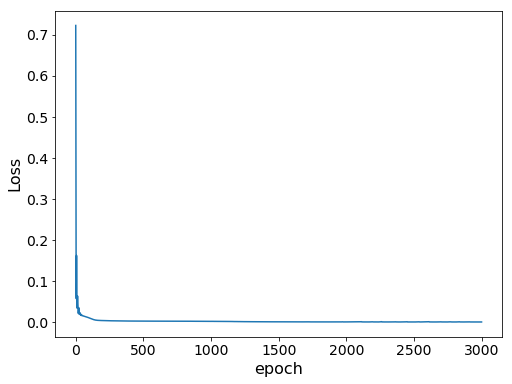

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), losses)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [12]:
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.00019624


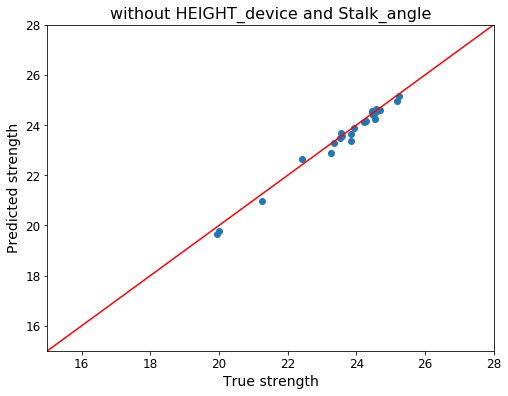

In [13]:
plt.figure(figsize=(8,6))
plt.title('without HEIGHT_device and Stalk_angle', fontsize=16)
plt.plot([15, 28], [15, 28], c='red')
plt.scatter(min_max_scaler_y.inverse_transform(y_test), min_max_scaler_y.inverse_transform(y_val))
plt.xlim((15, 28))
plt.ylim((15, 28))
plt.xlabel('True strength', fontsize=14)
plt.ylabel('Predicted strength', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [14]:
# R2 score
r2_strength = r2_score(min_max_scaler_y.inverse_transform(y_test), min_max_scaler_y.inverse_transform(y_val))
print(f'r2_strength: {r2_strength:.3f}')

r2_strength: 0.981


### Variable significance

In [15]:
losses_var = {'baseline': 0.00149192, 
              'WIDTH_mem': 0.00275577,
              'THICKNESS_mem': 0.01312068,
              'HEIGHT_chamber': 0.00119060,
              'HEIGHT_device': 0.00207556,
              'Stalk_angle': 0.00120367,
              'WIDTH_mem, THICKNESS_mem': 0.00985959,
              'WIDTH_mem, HEIGHT_chamber': 0.00684595,
              'WIDTH_mem, HEIGHT_device': 0.00423652,
              'WIDTH_mem, Stalk_angle': 0.00506612,
              'THICKNESS_mem, HEIGHT_chamber': 0.01752690,
              'THICKNESS_mem, HEIGHT_device': 0.01769614,
              'THICKNESS_mem, Stalk_angle': 0.00976107,
              'HEIGHT_chamber, HEIGHT_device': 0.00057927,
              'HEIGHT_chamber, Stalk_angle': 0.00115912,
              'HEIGHT_device, Stalk_angle': 0.00019624,
              'HEIGHT_chamber, HEIGHT_device, Stalk_angle': 0.00026928
#               'all but WIDTH_device': 4.13816118
             }

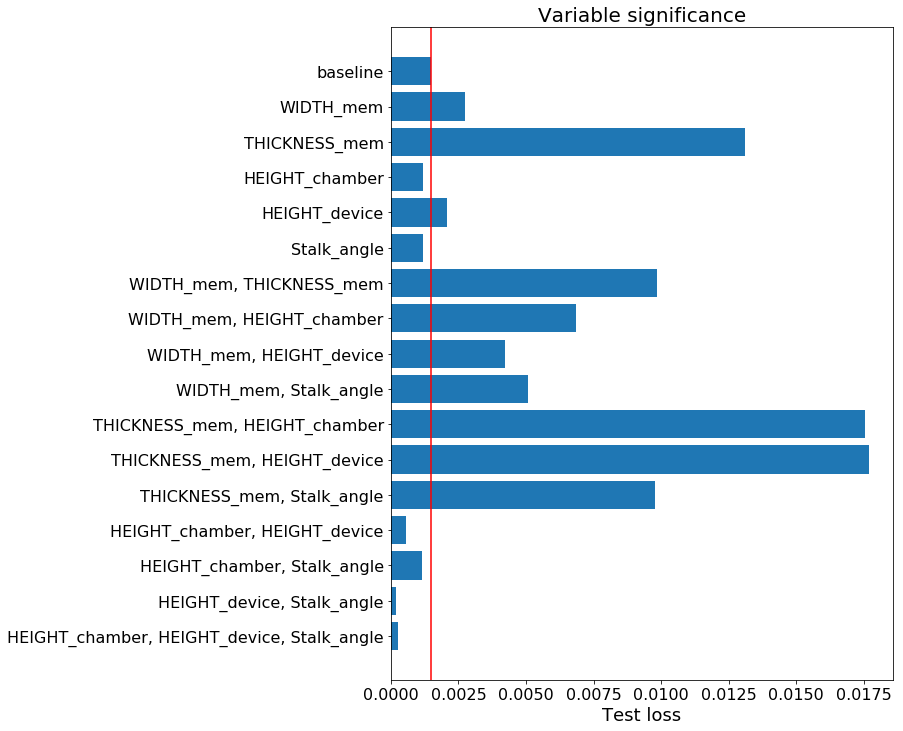

In [16]:
plt.figure(figsize=(9, 12))
plt.barh(list(losses_var.keys())[::-1], list(losses_var.values())[::-1])
plt.title('Variable significance', fontsize=20)
plt.xlabel('Test loss', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=0.00149192, color='red')
plt.show()